In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(u'fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import minepy
from kaggle.zillow.pysrc.data_load import *
from kaggle.zillow.pysrc.data_clean import *

In [2]:
load = Load()

featinfo = load.load_featinfo()
feat = load.load_property()
submission = load.load_submission()
train = load.load_train()

load featureInfo.csv ..
featinfo datashape: 58 X 7 ,cost time: 0.01s
load properties_2016.csv ..
properties datashape: 2985217 X 57 ,cost time: 19.69s
load sample_submission.csv ..
submission datashape: 2985217 X 7 ,cost time: 1.39s
load train.csv ...
train datashape: 90275 X 3 ,cost time: 0.09s


In [3]:
feat = clean_flow(feat)

extract nannum feat ...
------  cost time 5.83 seconds
binary feature clean ...
convert H_deck
convert F_pool2
convert N_pool
convert H_spaId
convert H_pool2
convert H_pool7
convert H_floor
convert F_fireplace
convert T_taxunpaid
------  cost time 9.04 seconds
drop_same_feature ...
leave feature:A_firstliving2 ,drop feature: A_firstliving1
leave feature:A_living1 ,drop feature: A_living2
leave feature:A_living1 ,drop feature: A_perimeter
leave feature:A_living1 ,drop feature: A_total
leave feature:A_living1 ,drop feature: A_base
leave feature:N_bathroom1 ,drop feature: N_bathroom2
leave feature:N_bathroom1 ,drop feature: N_bath
------  cost time 22.97 seconds
fillna city feature by knn ...
------  cost time 4.37 seconds
fillna zip feature by knn ...
------  cost time 4.03 seconds


In [5]:
corr = feat.corr()

## logerror

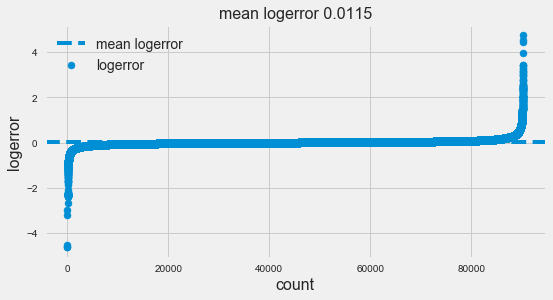

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(range(train.shape[0]), np.sort(train.logerror.values),label='logerror')
ax.set_ylabel('logerror',size=16)
ax.set_xlabel('count',size=16)
ax.axhline(train.logerror.mean(),linestyle='--',label='mean logerror')
ax.legend(fontsize=14)
ax.set_title('mean logerror %.4f'%(train.logerror.mean()), size=16)

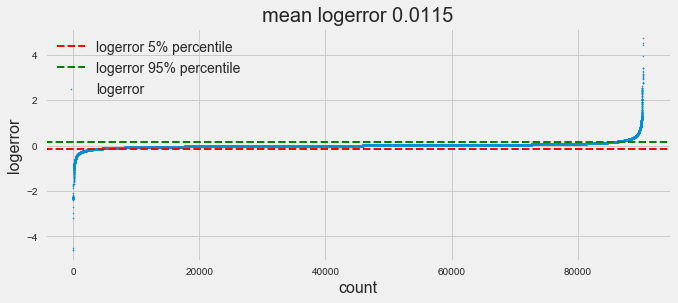

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(range(train.shape[0]), np.sort(train.logerror.values),label='logerror', s=1)
ax.set_ylabel('logerror',size=16)
ax.set_xlabel('count',size=16)
ax.axhline(np.percentile(train.logerror, 5),linestyle='--',label='logerror 5% percentile', c='r', linewidth=2)
ax.axhline(np.percentile(train.logerror, 95),linestyle='--',label='logerror 95% percentile', c='g',linewidth=2)
ax.legend(fontsize=14)
ax.set_title('mean logerror %.4f'%(train.logerror.mean()), size=20)

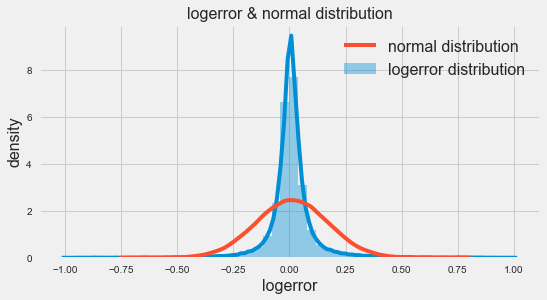

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(train.logerror.where((train.logerror<1)&(train.logerror>-1)).dropna(),label='logerror distribution')
sns.distplot(sp.stats.norm.rvs(sp.stats.tmean(train.logerror), 
                  sp.stats.tstd(train.logerror),
                  size=train.shape[0]), hist=False, label='normal distribution')
ax.set_xlabel('logerror', size=16)
ax.set_ylabel('density', size=16)
ax.legend(fontsize=16)
ax.set_title('logerror & normal distribution', size=16)

In [22]:
(train.groupby(np.sign(train.logerror))['logerror'].agg(['count','mean','std','min','max','median']))\
.rename(index={-1:'negative logerror',0:'zero logerror',1:'positive logerror'})

,count,mean,std,min,max,median
logerror,,,,,,
negative logerror,39667,-0.064849,0.134954,-4.605,-0.001,-0.0315
zero logerror,847,0.000000,0.000000,0.000,0.000,0.0000
positive logerror,49761,0.072480,0.155518,0.001,4.737,0.0344


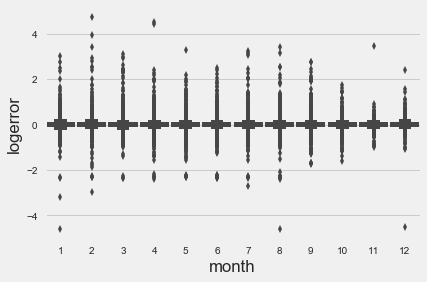

In [30]:
train['month'] = train.transactiondate.dt.month
sns.boxplot(x='month',y='logerror',data=train)

## nan feature

In [5]:
feat.shape

(2985217, 60)

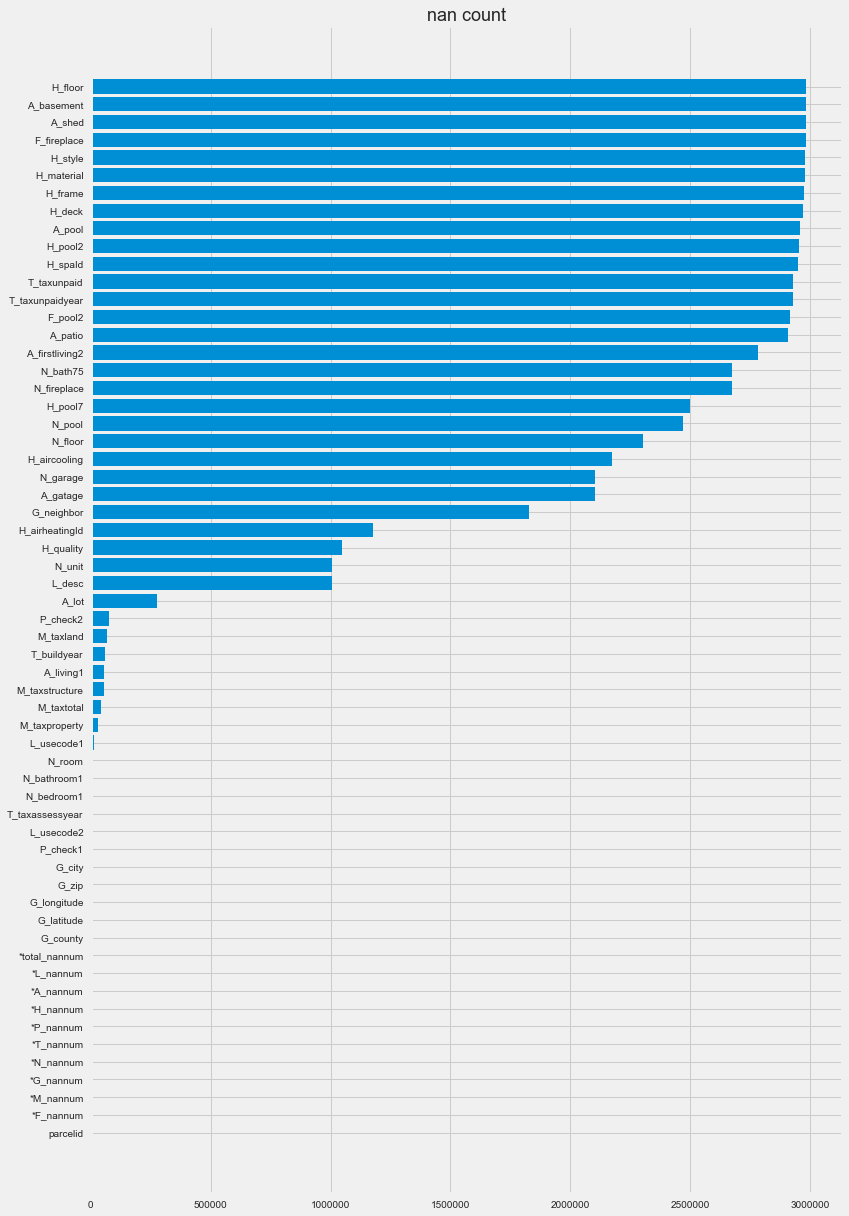

In [4]:
nan_count = feat.isnull().sum().sort_values()
fig, ax = plt.subplots(figsize=(12,20))
ax.barh(range(len(nan_count)),nan_count)
ax.set_yticks(range(len(nan_count)))
ax.set_yticklabels(nan_count.index)
ax.set_title('nan count', size=18)

## nan faeture

In [6]:
df = pd.merge(train, feat, on='parcelid', how='left')

df['abslogerror'] = df.logerror.abs()

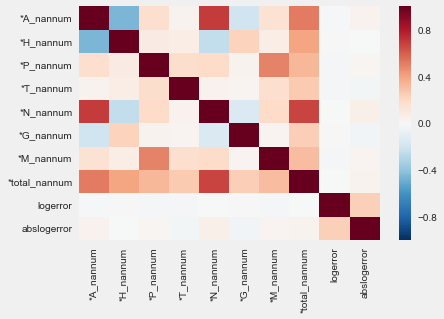

In [79]:
sns.heatmap(df[[c for c in df.columns if 'nannum' in c]+['logerror','abslogerror']].corr())

In [85]:
mine = minepy.MINE()
nannumfeat_infocoef = {}
for c in df.columns:
    if 'nannum' in c:
        mine.compute_score(df[c],df['logerror'])
        nannumfeat_infocoef[c] = mine.mic()

In [91]:
sorted(nannumfeat_infocoef.items(), key=lambda x: x[1], reverse=True)

[('*A_nannum', 0.019567212677019136),
 ('*N_nannum', 0.017408838084552795),
 ('*H_nannum', 0.015542852979251046),
 ('*G_nannum', 0.015500845101908498),
 ('*total_nannum', 0.012721542748454193),
 ('*T_nannum', 0.01233034387420951),
 ('*M_nannum', 0.007337417190811023),
 ('*P_nannum', 0.0071345130085772165)]

In [6]:
feat.head()

,parcelid,H_aircooling,H_style,A_basement,N_bathroom1,N_bedroom1,H_frame,H_quality,H_deck,A_firstliving1,...,P_check2,*A_nannum,*H_nannum,*P_nannum,*T_nannum,*N_nannum,*G_nannum,*M_nannum,*F_nannum,*total_nannum
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,12,11,1,3,8,1,2,2,40
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,12,11,1,3,8,1,2,2,40
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,10,11,1,3,7,1,0,2,35
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,NaN,10,9,1,2,7,0,0,2,31
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,10,10,1,2,7,0,0,2,32


In [7]:
for i in ['A','H','P','T','N','G','M','F','L']:
    print(df[[c for c in df.columns if c[0]==i]+['logerror','abslogerror']].corr())

                A_basement  A_living1  A_firstliving2  A_gatage     A_lot  \
A_basement        1.000000   0.341610       -0.031274  0.277500 -0.144900   
A_living1         0.341610   1.000000        0.689787  0.604360 -0.048770   
A_firstliving2   -0.031274   0.689787        1.000000  0.587275  0.351778   
A_gatage          0.277500   0.604360        0.587275  1.000000  0.244853   
A_lot            -0.144900  -0.048770        0.351778  0.244853  1.000000   
A_pool           -0.191167   0.308527        0.356320  0.283477  0.157942   
A_patio           0.017574   0.339667        0.356371  0.369438  0.173292   
A_shed           -0.329200   0.282325        0.343029  0.339119  0.393110   
logerror          0.253395   0.038784        0.023619  0.023888  0.004835   
abslogerror       0.212579   0.039368        0.031962  0.029417 -0.003365   

                  A_pool   A_patio    A_shed  logerror  abslogerror  
A_basement     -0.191167  0.017574 -0.329200  0.253395     0.212579  
A_living1   